# Stellargraph Ensembles for node attribute inference

This notebook demonstrates the use of `stellargraph`'s `Ensemble` class for node attribute inference using the Cora and Pubmed-Diabetes citation datasets.

The `Ensemble` class brings ensemble learning to `stellargraph`'s graph neural network models, e.g., `GraphSAGE` and `GCN`, quantifying prediction variance and potentially improving prediction accuracy. 

**References**

1. Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 
[cs.SI], 2017.


2. Semi-Supervised Classification with Graph Convolutional Networks. T. Kipf, M. Welling. ICLR 2017. arXiv:1609.02907 


3. Graph Attention Networks. P. Velickovic et al. ICLR 2018

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from stellargraph import Ensemble, BaggingEnsemble

from tensorflow.keras import layers, optimizers, losses, metrics, Model, models
from sklearn import preprocessing, feature_extraction, model_selection

import matplotlib.pyplot as plt
import seaborn as sns
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

### Loading the network data

In [2]:
display(HTML(datasets.Cora().description))
display(HTML(datasets.PubMedDiabetes().description))

First, we select the dataset to use, either Cora or Pubmed-Diabetes

In [3]:
use_cora = True  # Select the dataset; if False, then Pubmed-Diabetes dataset is used.
if use_cora:
    dataset = datasets.Cora()
else:
    dataset = datasets.PubMedDiabetes()

Load the graph data.

In [4]:
G, labels = dataset.load()

We aim to train a graph-ML model that will predict the "subject" or "label" attribute on the nodes depending on the selected dataset. These subjects are one of 7 or 3 categories for Cora and PubMed-Diabetes respectively:

In [5]:
# Print the class names for the selected dataset
print(set(labels))

{'Rule_Learning', 'Reinforcement_Learning', 'Probabilistic_Methods', 'Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Theory'}


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this

In [6]:
train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=0.2, test_size=None, stratify=labels, random_state=42,  # 140
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels,
    train_size=0.2,  # 500,
    test_size=None,
    stratify=test_labels,
    random_state=100,
)

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [7]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

### Specify global parameters

Here we specify some parameters that control the type of model we are going to use. For example, we specify the base model type, e.g., GCN, GraphSAGE, etc, and the number of estimators in the ensemble as well as model-specific parameters.

In [8]:
model_type = "graphsage"  # Can be either gcn, gat, or graphsage
use_bagging = (
    True  # If True, each model in the ensemble is trained on a bootstrapped sample
)
# of the given training data; otherwise, the same training data are used
# for training each model.

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 50
    num_samples = [10, 10]
    n_estimators = 5  # The number of estimators in the ensemble
    n_predictions = 10  # The number of predictions per estimator per query point
    epochs = 50  # The number of training epochs
elif model_type == "gcn":
    # For GCN model
    n_estimators = 5  # The number of estimators in the ensemble
    n_predictions = 10  # The number of predictions per estimator per query point
    epochs = 50  # The number of training epochs
elif model_type == "gat":
    # For GAT model
    layer_sizes = [8, train_targets.shape[1]]
    attention_heads = 8
    n_estimators = 5  # The number of estimators in the ensemble
    n_predictions = 10  # The number of predictions per estimator per query point
    epochs = 200  # The number of training epochs

## Creating the base graph machine learning model in Keras

To feed data from the graph to the Keras model we need a generator that feeds data from the graph into the model. The generators are specialized to the model and the learning task. 

For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training for those generators that support shuffling.

In [9]:
if model_type == "graphsage":
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
    train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)
elif model_type == "gcn":
    generator = FullBatchNodeGenerator(G, method="gcn")
    train_gen = generator.flow(
        train_labels.index, train_targets
    )  # does not support shuffle
elif model_type == "gat":
    generator = FullBatchNodeGenerator(G, method="gat")
    train_gen = generator.flow(
        train_labels.index, train_targets
    )  # does not support shuffle

In [10]:
len(train_labels.index)

541

Now we can specify our machine learning model, we need a few more parameters for this but the parameters are model-specific.

In [11]:
if model_type == "graphsage":
    base_model = GraphSAGE(
        layer_sizes=[16, 16], generator=generator, bias=True, dropout=0.5, normalize="l2"
    )
    x_inp, x_out = base_model.build()
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
elif model_type == "gcn":
    base_model = GCN(
        layer_sizes=[32, train_targets.shape[1]],
        generator=generator,
        bias=True,
        dropout=0.5,
        activations=["elu", "softmax"],
    )
    x_inp, x_out = base_model.build()
    prediction = x_out
elif model_type == "gat":
    base_model = GAT(
        layer_sizes=layer_sizes,
        attn_heads=attention_heads,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        activations=["elu", "softmax"],
    )
    x_inp, prediction = base_model.build()

Let's have a look at the shape of the output tensor.

In [12]:
prediction.shape

TensorShape([None, 7])

### Create a Keras model and then an Ensemble

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `base_model` and outputs being the predictions from the softmax layer.

In [13]:
model = Model(inputs=x_inp, outputs=prediction)

Next, we create the ensemble model consisting of `n_estimators` models.

We are also going to specify that we want to make `n_predictions` per query point per model. These predictions will differ because of the application of `dropout` and, in the case of ensembling GraphSAGE models, the sampling of node neighbourhoods.

In [14]:
if use_bagging:
    model = BaggingEnsemble(model, n_estimators=n_estimators, n_predictions=n_predictions)
else:
    model = Ensemble(model, n_estimators=n_estimators, n_predictions=n_predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [15]:
# The model is of type stellargraph.ensemble.Ensemble but has
# a very similar interface to a Keras model
model

The ensemble has `n_estimators` models. Let's have a look at the first model's layers.

In [16]:
model.layers(0)

Train the model, keeping track of its loss and accuracy on the training set, and its performance on the validation set during the training (e.g., for early stopping), and generalization performance of the final model on a held-out test set (we need to create another generator over the test data for this)

In [17]:
val_gen = generator.flow(val_labels.index, val_targets)
test_gen = generator.flow(test_labels.index, test_targets)

Note that the amount of time to train the ensemble is linear to `n_estimators`.

Also, we are going to use early stopping by monitoring the accuracy on the validation data and stopping if the accuracy does not increase after 10 training epochs (this is the default grace value specified by the `Ensemble` class but we can set it to a different value by using `model.early_stopping_patience=20` for example.)

In [18]:
if use_bagging:
    # When using bootstrap samples to train each model in the ensemble, we must specify
    # the IDs of the training nodes (train_data) and their corresponding target values
    # (train_targets)
    history = model.fit_generator(
        generator,
        train_data=train_labels.index,
        train_targets=train_targets,
        epochs=epochs,
        validation_data=val_gen,
        verbose=0,
        shuffle=False,
        bag_size=None,
        use_early_stopping=True,  # Enable early stopping
        early_stopping_monitor="val_acc",
    )
else:
    history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=0,
        shuffle=False,
        use_early_stopping=True,  # Enable early stopping
        early_stopping_monitor="val_acc",
    )

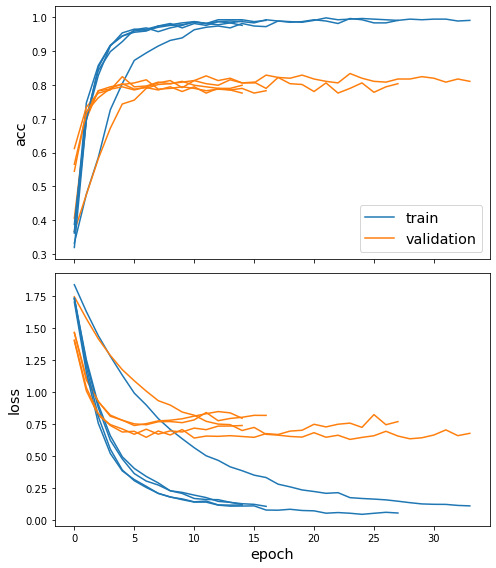

In [19]:
sg.utils.plot_history(history)

Now we have trained the model, let's evaluate it on the test set. Note that the `.evaluate_generator()` method of the `Ensemble` class returns mean and standard deviation of each evaluation metric.

In [20]:
test_metrics_mean, test_metrics_std = model.evaluate_generator(test_gen)

print("\nTest Set Metrics of the trained models:")
for name, m, s in zip(model.metrics_names, test_metrics_mean, test_metrics_std):
    print("\t{}: {:0.4f}±{:0.4f}".format(name, m, s))


Test Set Metrics of the trained models:
	loss: 0.7173±0.0254
	acc: 0.7988±0.0055


### Making predictions with the model

Now let's get the predictions for all nodes, using a new generator for all nodes:

In [21]:
all_nodes = labels.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict_generator(generator=all_gen)

In [22]:
all_predictions.shape

(5, 10, 2708, 7)

For full-batch methods, the batch dimension is 1 so we will remove any singleton dimensions

In [23]:
all_predictions = np.squeeze(all_predictions)

In [24]:
all_predictions.shape

(5, 10, 2708, 7)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

For demonstration, we are going to select one of the nodes in the graph, and plot the ensemble's predictions for that node.

In [25]:
selected_query_point = -1

The array `all_predictions` has dimensionality $MxKxNxF$ where $M$ is the number of estimators in the ensemble (`n_estimators`); $K$ is the number of predictions per query point per estimator (`n_predictions`); $N$ is the number of query points (`len(all_predictions)`); and $F$ is the output dimensionality of the specified layer determined by the shape of the output layer.

Since we are only interested in the predictions for a single query node, e.g., `selected_query_point`, we are going to slice the array to extract them.

In [26]:
# Select the predictions for the point specified by selected_query_point
qp_predictions = all_predictions[:, :, selected_query_point, :]
# The shape should be n_estimators x n_predictions x size_output_layer
qp_predictions.shape

(5, 10, 7)

Next, to facilitate plotting the predictions using either a density plot or a box plot, we are going to reshape `qp_predictions` to $R\times F$ where $R$ is equal to $M\times K$ as above and $F$ is the output dimensionality of the output layer.

In [27]:
qp_predictions = qp_predictions.reshape(
    np.product(qp_predictions.shape[0:-1]), qp_predictions.shape[-1]
)
qp_predictions.shape

(50, 7)

In [28]:
inv_subject_mapper = {k: v for k, v in enumerate(target_encoding.classes_)}
inv_subject_mapper

{0: 'Case_Based',
 1: 'Genetic_Algorithms',
 2: 'Neural_Networks',
 3: 'Probabilistic_Methods',
 4: 'Reinforcement_Learning',
 5: 'Rule_Learning',
 6: 'Theory'}

We'd like to assess the ensemble's confidence in its predictions in order to decide if we can trust them or not. Utilising density plots, we can visually inspect the ensemble's distribution of prediction probabilities for a node's label.

This is better demonstrated if the ensemble's base mode is `GraphSAGE` because the predictions of the base model vary most (when compared to GCN and GAT) due to the random sampling of node neighbours during prediction in addition to the inherent stocasticity of the ensemble itself.

If the density plot for the predicted node label is well separated from those of the other labels with little overlap then we can be confident trusting the model's prediction.

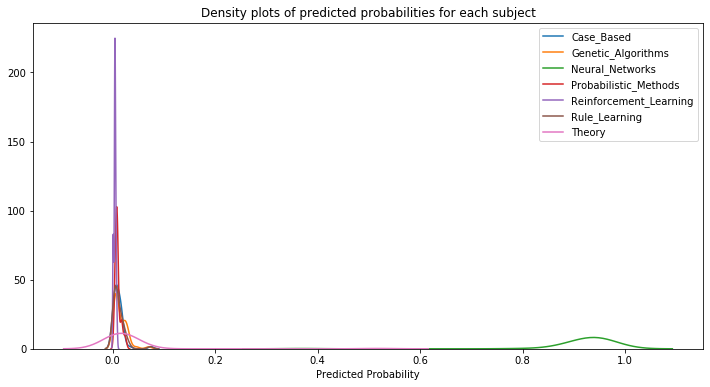

In [29]:
if model_type not in ["gcn", "gat"]:
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(qp_predictions.shape[1]):
        sns.kdeplot(data=qp_predictions[:, i].reshape((-1,)), label=inv_subject_mapper[i])
    plt.xlabel("Predicted Probability")
    plt.title("Density plots of predicted probabilities for each subject")

An alternative and possibly more informative view of the distribution of node predictions is a box plot.

Text(0.5, 0, 'Subject')

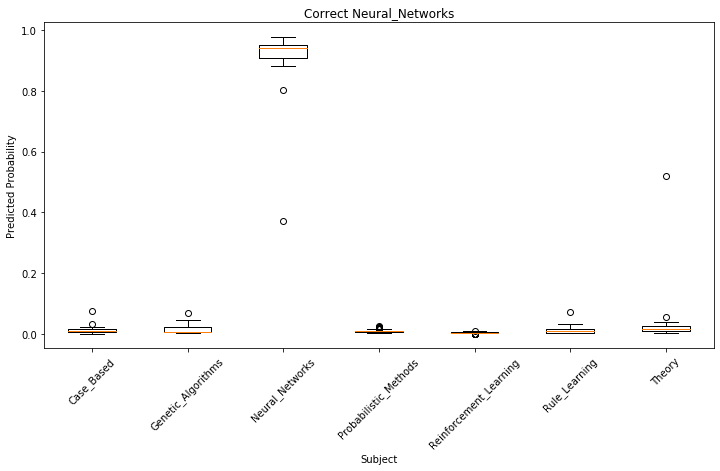

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(x=qp_predictions)
ax.set_xticklabels(target_encoding.classes_)
ax.tick_params(axis="x", rotation=45)
if model_type == "graphsage":
    y = np.argmax(target_encoding.transform(labels), axis=1)
elif model_type == "gcn" or model_type == "gat":
    y = np.argmax(target_encoding.transform(labels.reindex(G.nodes())), axis=1)
plt.title(f"Correct {target_encoding.classes_[y[selected_query_point]]}")
plt.ylabel("Predicted Probability")
plt.xlabel("Subject")

The above example shows that the ensemble predicts the correct node label with high confidence so we can trust its prediction.

(Note that due to the stochastic nature of training neural network algorithms, the above conclusion may not be valid if you re-run the notebook; however, the general conclusion that the use of ensemble learning can be used to quantify the model's uncertainty about its predictions still holds.)

## Node embeddings

Evaluate node embeddings as activations of the output of one of the graph convolutional or aggregation layers in the ensemble model, and visualise them, coloring nodes by their subject label.

You can find the index of the layer of interest by calling the `Ensemble` class's method `layers`, e.g., `model.layers()`.

In [31]:
if model_type == "graphsage":
    # For GraphSAGE, we are going to use the output activations of the second GraphSAGE layer
    # as the node embeddings
    emb = model.predict_generator(
        generator=generator, predict_data=labels.index, output_layer=-4
    )  # this selects the output layer
elif model_type == "gcn" or model_type == "gat":
    # For GCN and GAT, we are going to use the output activations of the first GCN or Graph
    # Attention layer as the node embeddings
    emb = model.predict_generator(
        generator=generator, predict_data=labels.index, output_layer=6
    )  # this selects the output layer

The array `emb` has dimensionality $MxKxNxF$ (or $MxKx1xNxF$for full batch methods) where $M$ is the number of estimators in the ensemble (`n_estimators`); $K$ is the number of predictions per query point per estimator (`n_predictions`); $N$ is the number of query points (`len(node_data.index)`); and $F$ is the output dimensionality of the specified layer determined by the shape of the readout layer as specified above.

In [32]:
emb.shape

(5, 10, 2708, 1, 16)

In [33]:
emb = np.squeeze(emb)
emb.shape

(5, 10, 2708, 16)

Next we are going to average the predictions over the number of models and the number of predictions per query point. 

The dimensionality of the array will then be **NxF** where N is the number of points to predict (equal to the number of nodes in the graph for this example) and F is the dimensionality of the embeddings that depends on the output shape of the readout layer as specified above.

Note that we could have achieved the same by specifying `summarise=True` in the call to the method `predict_generator` above.

In [34]:
emb = np.mean(emb, axis=(0, 1))

In [35]:
emb.shape

(2708, 16)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [36]:
X = emb
y = np.argmax(target_encoding.transform(labels), axis=1)

In [37]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=labels.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=labels.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

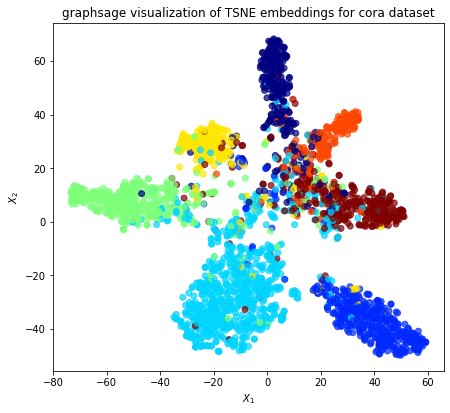

In [38]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of {} embeddings for cora dataset".format(
        model_type, transform.__name__
    )
)
plt.show()